## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

In [226]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [227]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"C:\ERDC\BarSed")

# Import the library modules

from lib.data_classes.Run import Run

In [228]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [229]:
# Fuctions
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

### Set the information for the selected Run

In [230]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed"

# Set the information needed for specifying the run
# Run number
run_number = "082"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

### Get the bathymetry for the model

In [231]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: D:\ERDC\BarSed\bathy.mat


### Get the path to the wave gauge data

In [232]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run082 wave mat file path: D:\ERDC\BarSed\WG\RUN082.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [233]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: D:\ERDC\BarSed\ADV
ADV Data for mat file path: D:\ERDC\BarSed\ADV\RUN082.mat


### Collect the bathymetry data

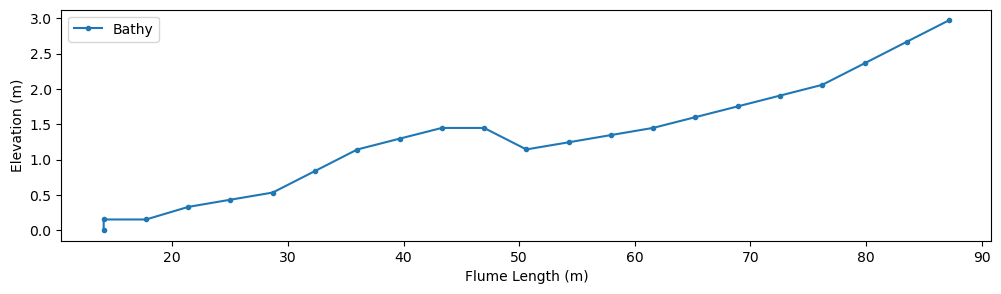

In [234]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

### Construct the Run object
This object will help organize the data and help store the data

In [235]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_data)


id: RUN082
Start Date: None
Wave Data File path: D:\ERDC\BarSed\WG\RUN082.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 8362


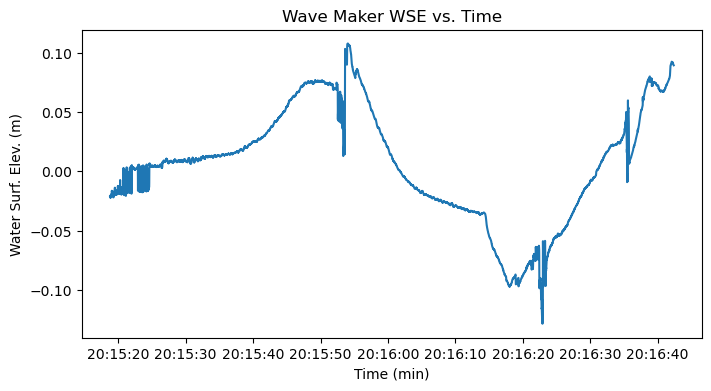

In [236]:
Run_data.load_wave_data()

print(Run_data.wave_maker)

Run_data.wave_maker.quick_wse_plot()

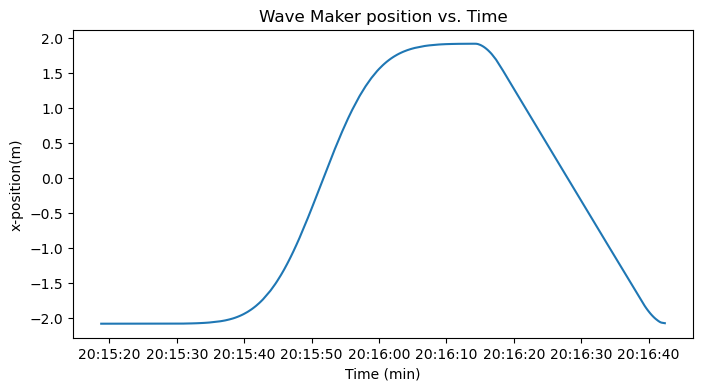

In [237]:
Run_data.wave_maker.quick_position_plot()

## Smoothing the surface data

In [238]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_data.wave_maker.date_time])


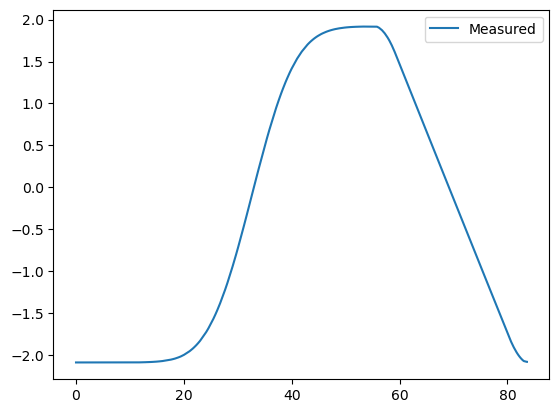

In [239]:
# Plot the theoretical and the measured wave maker displacement

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_data.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

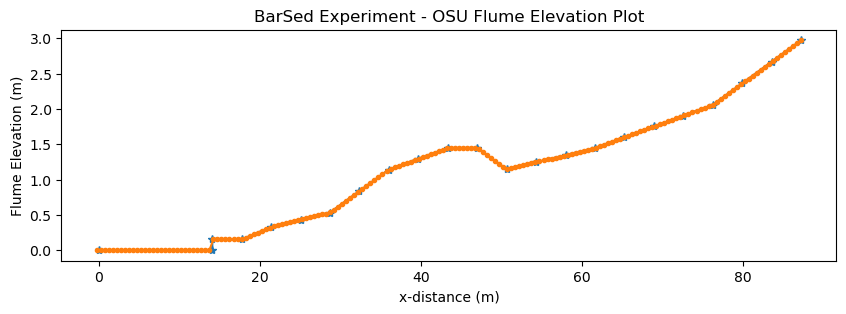

In [240]:
# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

# Add the zero to the arrays
x = np.concatenate(([0.0], x))
z = np.concatenate(([0.0], z))

# x_zero = np.array(0, )
xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 0.5)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


### Generating the wave data

In [241]:
print(Run_data)

id: RUN082
Start Date: 2015-01-30
Wave Data File path: D:\ERDC\BarSed\WG\RUN082.mat
Num pressure gagues: None
Num advs: None


In [242]:
print(Run_data.wave_gauges[0])

Wave Gauge Type: self_calibrating
Gauge Id: 1
Location: (17.728, -1.269)


In [243]:
def moving_average_filter(data, window_size):
    """
    Applies a moving average filter to the input data.

    Parameters:
    - data: The input array of data points (list or numpy array).
    - window_size: The size of the moving window.

    Returns:
    - filtered_data: The filtered data as a numpy array.
    """
    # Convert data to a numpy array if it is not already
    data = np.array(data)
    
    # Ensure the window size is an integer
    window_size = int(window_size)
    
    # Check if window size is greater than 0 and less than or equal to the length of data
    if window_size <= 0 or window_size > len(data):
        raise ValueError("Window size must be greater than 0 and less than or equal to the length of the data.")
    
    # Compute the moving average using np.convolve with 'valid' mode to avoid padding effects
    filtered_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    return filtered_data

Water surface elevation: 2.971 [m]


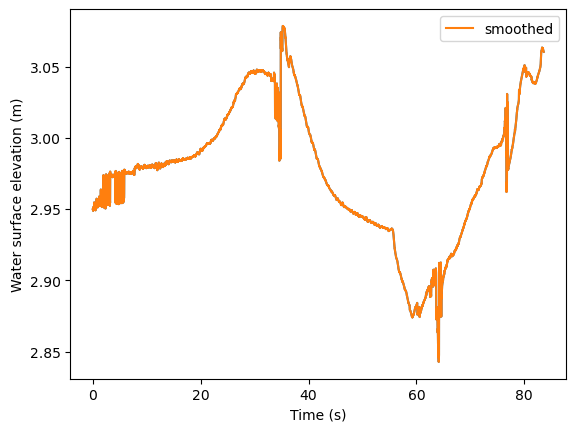

In [244]:
# Set information
zs0 = zgr.max()

# Offset the water suface elevation from the bottom
eta = zs0 + Run_data.wave_maker.eta_wm

window_size = 1
smoothed_eta  = moving_average_filter(eta, window_size)
smoothed_time = moving_average_filter(seconds_from_first, window_size) 

# Shift the time so that it starts at zero
smoothed_time = smoothed_time - smoothed_time[0]

print(f"Water surface elevation: {zs0} [m]")
plt.plot(seconds_from_first, eta)
plt.plot(smoothed_time, smoothed_eta, label ="smoothed")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Water surface elevation (m)")
plt.show()

### Generating the computational params for the model

In [245]:
xb_setup = XBeachModelSetup('Rand_vel_v1_1')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [246]:
# Generate a random u velocity for the time being
u_avg = np.ones(len(smoothed_time)) * 0.1

zs_scaling = 2.0

boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : smoothed_time,
                   "U" : u_avg, # NOTE: Changed these to surface velocities 
                   "zs": zs_scaling * (smoothed_eta - zs0) # Pertubation from the intial water surface
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)

print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")


In [247]:
xb_setup.set_params({ "wbctype"     : "ts_nonh",
                     "wavemodel"    : "nonh",
                     "nonh"         : 1,
                     "CFL"          : 0.5,
                     'nonhq3d'      : 1,
                     'nhlay'        : 0.33, 
                     "lateralwave"  : "neumann",
                     "zs0"          : zs0,
                    #  'bedfriccoef'  : 0.0,
                     "order"        : 1,
                    #  "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "neumann", "right": "neumann",
                     "tstop"        : smoothed_time.max(),
                     "outputformat" : "netcdf",
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [248]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh',
  'lateralwave': 'neumann'},
 'Physical processes': {'wavemodel': 'nonh'},
 'Model time': {'CFL': 0.5, 'tstop': 83.609997},
 'Non-hydrostatic correction parameters': {'nonhq3d': 1, 'nhlay': 0.33},
 'Tide boundary conditions': {'zs0': 2.971},
 'Flow boundary condition parameters': {'order': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'neumann',
  'right': 'neumann'},
 'Output': {'outputformat': 'netcdf',
  'tintm': 0.1,
  'tintp': 0.1,
  'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

### Generating the model files

In [249]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"C:\ERDC\tutorial_models\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")


Directory 'c:\ERDC\BarSed_xBeach_models\Solitary_Wave_Models\Run_082_nonhq3d\' already exists.


In [250]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to c:\ERDC\BarSed_xBeach_models\Solitary_Wave_Models\Run_082_nonhq3d\boun_U.bcf


In [251]:
# Write the wave maker data to a txt file

# Time, location, wse
data = {"time"     : seconds_from_first,     
        "location" : Run_data.wave_maker.position,
        "wse"      : Run_data.wave_maker.eta_wm + zs0
        }
df = pd.DataFrame(data)
display(df)
df.to_csv("wave_maker.csv", index = False)

,time,location,wse
0,0.000000,-2.0847,2.949702
1,0.009998,-2.0847,2.949380
2,0.020006,-2.0850,2.949316
3,0.030004,-2.0848,2.949960
4,0.039992,-2.0847,2.949960
...,...,...,...
8357,83.570006,-2.0770,3.060711
8358,83.580004,-2.0771,3.060711
8359,83.590002,-2.0774,3.060518
8360,83.599999,-2.0774,3.060518
